In [1]:
import torch
import sys
import os
from model import RNNTrainer,RNN_quantum
import numpy as np

import matplotlib.pyplot as plt
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


`Подготовка данных`

In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
window_size=100
num_features=9
downsample_step=25 # 0.003 * downsample_step = шаг данных в секундах
target_window_size = 20 # output size количество выходных данных для 1 примера
# Подготовка данных
X, y, df = PD.many_to_many(
    window_size=window_size,
    num_features=num_features,
    downsample_step=downsample_step,
    target_window_size=target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = PD.PDtrain_test_split(
    X, y, test_size=0.33, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6303, 100, 9]),
 torch.Size([3105, 100, 9]),
 torch.Size([6303, 20]),
 torch.Size([3105, 20]))

`Инициализация модели`

In [3]:
input_size = X_train.shape[2]
output_size = 1
hidden_size = 512
output_sw = target_window_size
num_layers = 1
num_bands = 5
temperature= 0.9
mn_c = -4.0,
mx_c = 4.0,
c_mb = 1.0,
c_bi = 0.5,
dropout = 0.1
dropout_band = 0.05
model = RNN_quantum( 
    input_size = input_size,
    output_size = output_size,
    hidden_size = hidden_size,
    output_sw = output_sw,
    num_layers = num_layers,
    num_bands = num_bands,
    temperature = temperature,
    dropout=dropout,
    dropout_band = dropout_band,
    mn_c = mn_c,
    mx_c = mx_c,
    c_mb= c_mb,
    c_bi=c_bi,
    device = device)

#model.load_state_dict(torch.load('best_model_weights.pth'))
lr = 0.001
trainer = RNNTrainer(
    model=model,
    learning_rate=lr,
    inf_per_epoch = 5,
    device= device
)


`Обучение`

In [10]:
batch_size = 32
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=batch_size, 
    weight_i = False,
    info = False,
    epochs=100,
    loss_tube=5
)

Epoch 5
Train - Total: 0.974379, Main: 0.592045, MAPE: 0.159232, Alpha: 0.643651 Tube: 0.213257
Test - Total: 0.998378, Main: 0.606156, MAPE: 0.160712, Alpha: 0.647064, Tube: 0.196119
Epoch 10
Train - Total: 0.974668, Main: 0.592297, MAPE: 0.159231, Alpha: 0.643734 Tube: 0.212639
Test - Total: 1.005258, Main: 0.610008, MAPE: 0.168187, Alpha: 0.647943, Tube: 0.178052
Epoch 15
Train - Total: 0.967209, Main: 0.587954, MAPE: 0.158307, Alpha: 0.642695 Tube: 0.204562
Test - Total: 0.996565, Main: 0.605141, MAPE: 0.164051, Alpha: 0.646832, Tube: 0.174396
Epoch 20
Train - Total: 0.826036, Main: 0.506098, MAPE: 0.132166, Alpha: 0.623139 Tube: 0.231179
Test - Total: 0.571346, Main: 0.359577, MAPE: 0.088110, Alpha: 0.588938, Tube: 0.349243
Epoch 25
Train - Total: 0.533641, Main: 0.336721, MAPE: 0.088088, Alpha: 0.583352 Tube: 0.347800
Test - Total: 0.416622, Main: 0.266023, MAPE: 0.068197, Alpha: 0.566116, Tube: 0.445523
Epoch 30
Train - Total: 0.515110, Main: 0.325469, MAPE: 0.085064, Alpha: 0.5

`Сохранение истории ошибок и результатов включая гиперпараметров модели и обучения`

In [11]:
from model_history import ModelHistory
MH = ModelHistory(history)
MH.save_history_json(filename = BASE_DIR+'\loss_history/all_loss.json',model_name = 'QUANT_RNN')
key = MH.add_result(
        filename = BASE_DIR+'\\resualt/main.json',
        model_name = 'QUANT_RNN',
        result = 'best',
        message = 'тестовое обучение',
        params = {'input_size' : input_size,
                  'output_size' : output_size,
                  'hidden_size' : hidden_size,
                  'output_sw' : output_sw,
                  'num_layers' : num_layers,
                  'num_bands':num_bands,
                  'temperature':temperature,
                  'dropout':dropout,
                  'dropout_band':dropout_band,
                  'mn_c': mn_c,
                  'mx_c': mx_c,
                  'c_mb': c_mb,
                  'c_bi':c_bi,
                  'lr':lr,
                  'batch_size':batch_size,
                  'window_size':window_size,
                  'num_features':num_features,
                  'downsample_step':downsample_step,
                  'target_window_size':target_window_size}
        )
key

'c63b1029-cf1f-46c2-b4c4-50cdce43c5a7'

In [4]:
key = 'c63b1029-cf1f-46c2-b4c4-50cdce43c5a7'
model.load_state_dict(torch.load(f'weights/{key}.pth'))

<All keys matched successfully>

сохранение весом под ключем

In [12]:

temp_w = torch.load('best_model_weights.pth')
try:
    model.load_state_dict(temp_w)
    print("Веса успешно загружены и совместимы с текущей моделью.")
except RuntimeError as e:
    print(f"Ошибка при загрузке весов: {e}")

torch.save(temp_w, f'weights/{key}.pth')

Веса успешно загружены и совместимы с текущей моделью.


<div style="background-color: #f4f4f9; padding: 20px; border-radius: 10px; text-align: center;">
    <h1 style="color: #29c0f2; font-weight: bold; margin-top: 15px;">Визуализация ошибок</h1>
</div>

In [13]:
LV = LossVisualizer(history)

<div style="background-color: #f4f4f9; padding: 20px; border-radius: 10px; text-align: center;">
    <b style="color: #eb2a91; font-weight: bold; margin-top: 15px;">визуализация параметров модели.</b>
</div>

Слой: layers.0.quantum_layer1.transition_weights, Размер: torch.Size([5, 5, 512])
Визуализация для слоя layers.0.quantum_layer1.transition_weights с размерностью (5, 5, 512) не поддерживается.
Слой: layers.0.quantum_layer1.energy_bands.0.weight, Размер: torch.Size([512, 521])


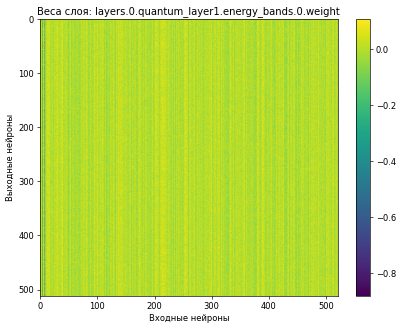

Слой: layers.0.quantum_layer1.energy_bands.1.weight, Размер: torch.Size([512, 521])


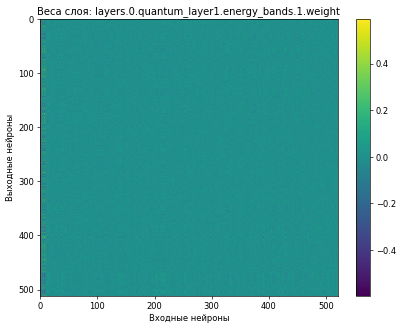

Слой: layers.0.quantum_layer1.energy_bands.2.weight, Размер: torch.Size([512, 521])


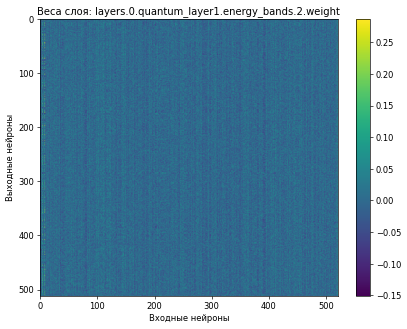

Слой: layers.0.quantum_layer1.energy_bands.3.weight, Размер: torch.Size([512, 521])


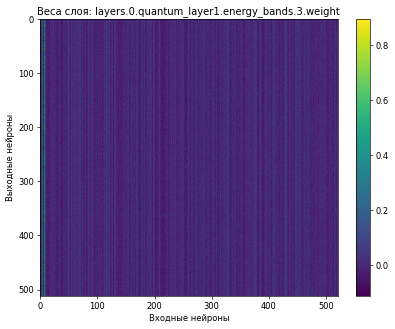

Слой: layers.0.quantum_layer1.energy_bands.4.weight, Размер: torch.Size([512, 521])


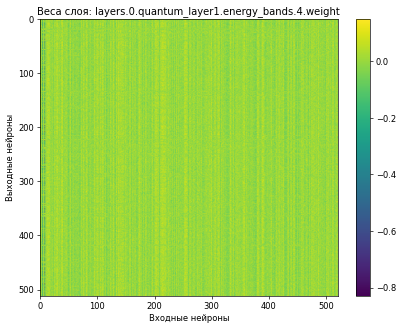

Слой: layers.0.quantum_layer1.quantum_projections.0.weight, Размер: torch.Size([512, 512])


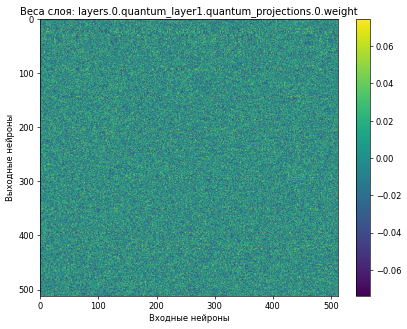

Слой: layers.0.quantum_layer1.quantum_projections.1.weight, Размер: torch.Size([512, 512])


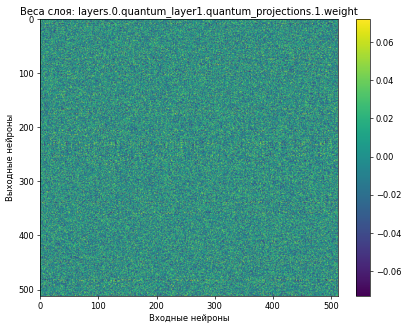

Слой: layers.0.quantum_layer1.quantum_projections.2.weight, Размер: torch.Size([512, 512])


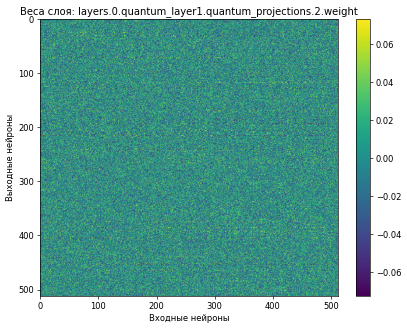

Слой: layers.0.quantum_layer1.quantum_projections.3.weight, Размер: torch.Size([512, 512])


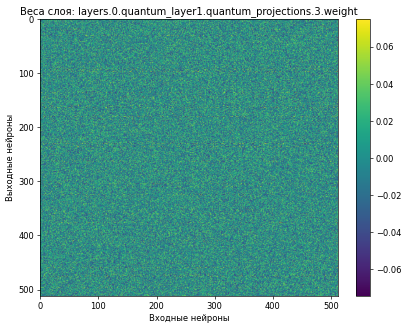

Слой: layers.0.quantum_layer1.quantum_projections.4.weight, Размер: torch.Size([512, 512])


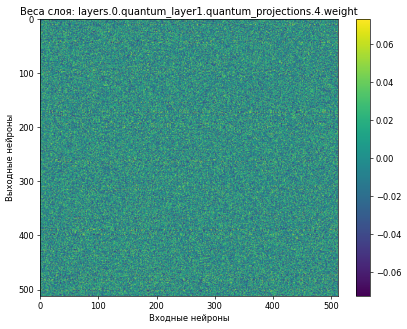

Слой: layers.0.norm1.weight, Размер: torch.Size([512])
Визуализация для слоя layers.0.norm1.weight с размерностью (512,) не поддерживается.
Слой: layers.0.output_layer.weight, Размер: torch.Size([512, 512])


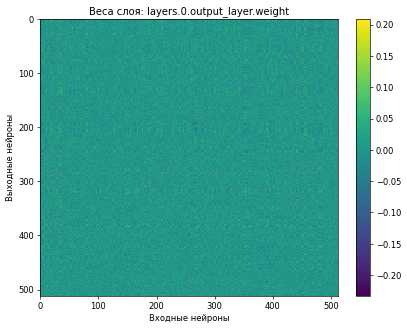

Слой: layers.0.h_s.weight, Размер: torch.Size([512, 512])


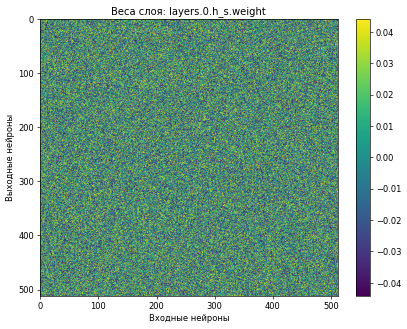

Слой: layers_follow.0.quantum_layer1.transition_weights, Размер: torch.Size([5, 5, 512])
Визуализация для слоя layers_follow.0.quantum_layer1.transition_weights с размерностью (5, 5, 512) не поддерживается.
Слой: layers_follow.0.quantum_layer1.energy_bands.0.weight, Размер: torch.Size([512, 512])


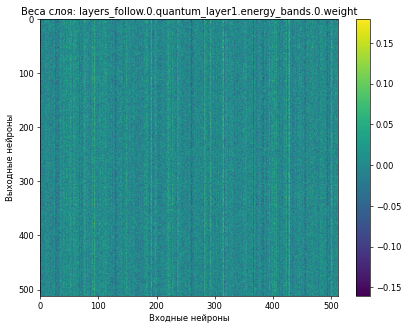

Слой: layers_follow.0.quantum_layer1.energy_bands.1.weight, Размер: torch.Size([512, 512])


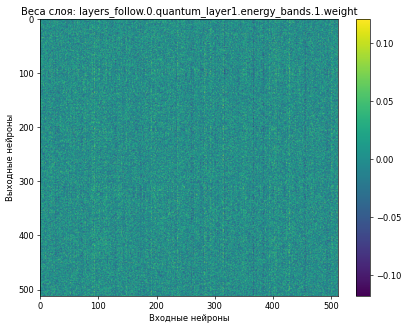

Слой: layers_follow.0.quantum_layer1.energy_bands.2.weight, Размер: torch.Size([512, 512])


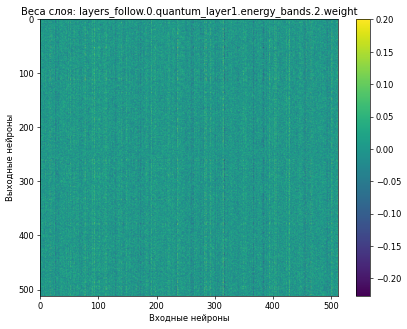

Слой: layers_follow.0.quantum_layer1.energy_bands.3.weight, Размер: torch.Size([512, 512])


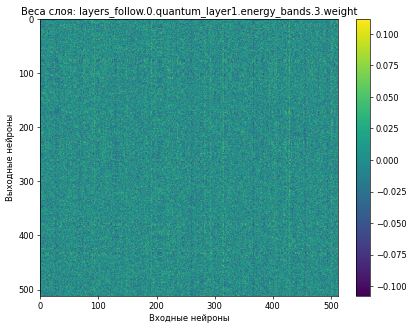

Слой: layers_follow.0.quantum_layer1.energy_bands.4.weight, Размер: torch.Size([512, 512])


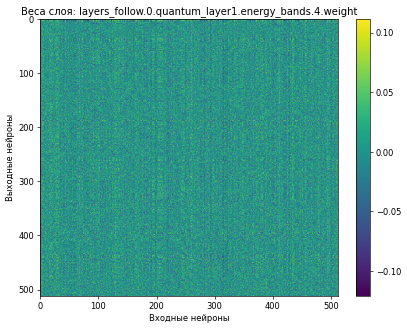

Слой: layers_follow.0.quantum_layer1.quantum_projections.0.weight, Размер: torch.Size([512, 512])


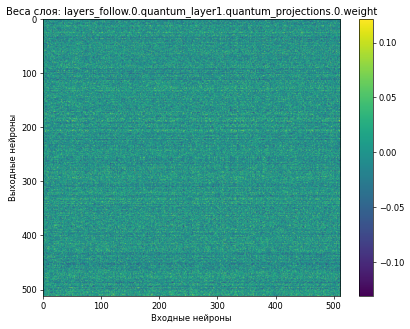

Слой: layers_follow.0.quantum_layer1.quantum_projections.1.weight, Размер: torch.Size([512, 512])


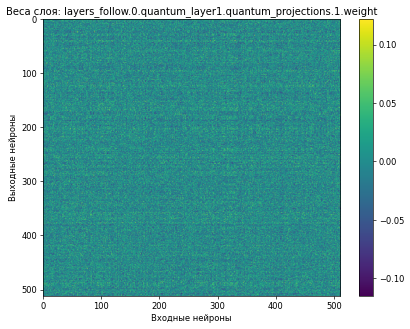

Слой: layers_follow.0.quantum_layer1.quantum_projections.2.weight, Размер: torch.Size([512, 512])


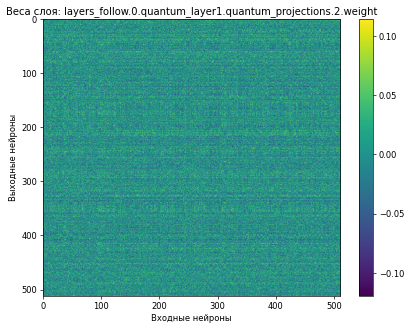

Слой: layers_follow.0.quantum_layer1.quantum_projections.3.weight, Размер: torch.Size([512, 512])


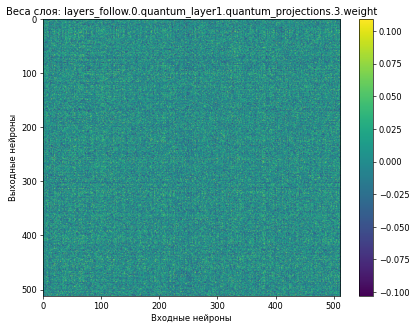

Слой: layers_follow.0.quantum_layer1.quantum_projections.4.weight, Размер: torch.Size([512, 512])


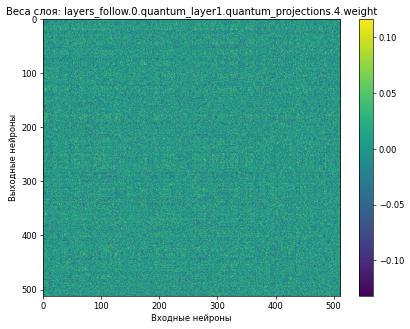

Слой: layers_follow.0.norm1.weight, Размер: torch.Size([512])
Визуализация для слоя layers_follow.0.norm1.weight с размерностью (512,) не поддерживается.
Слой: layers_follow.0.output_layer.weight, Размер: torch.Size([512, 512])


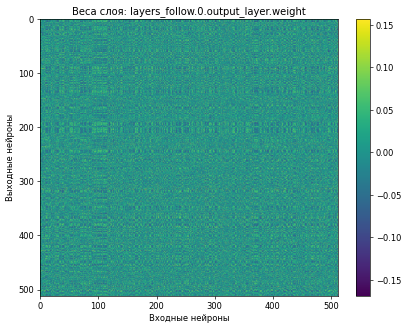

Слой: layers_follow.0.h_s.weight, Размер: torch.Size([512, 512])


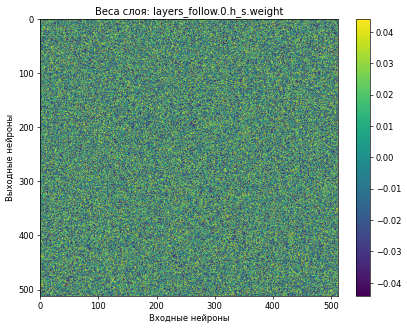

Слой: fc.weight, Размер: torch.Size([1, 512])


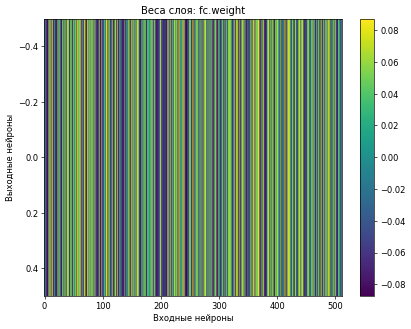

In [14]:
wg= model.parameters()
LV.show_weight(model)

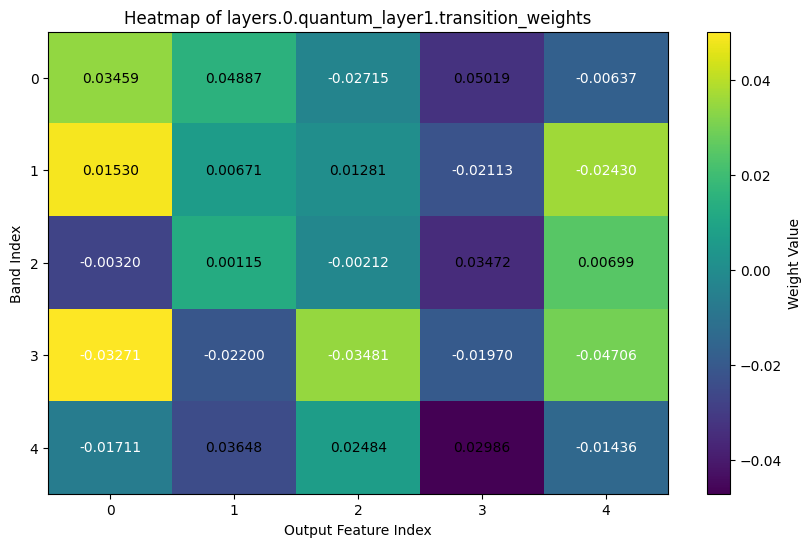

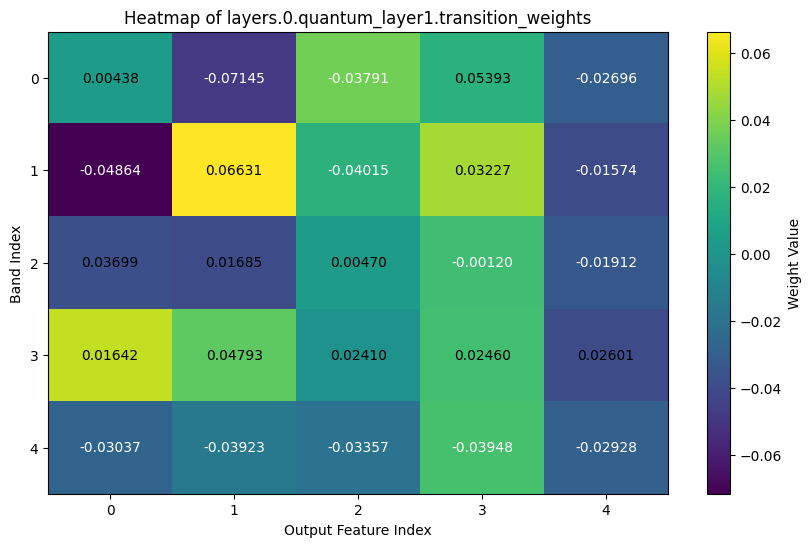

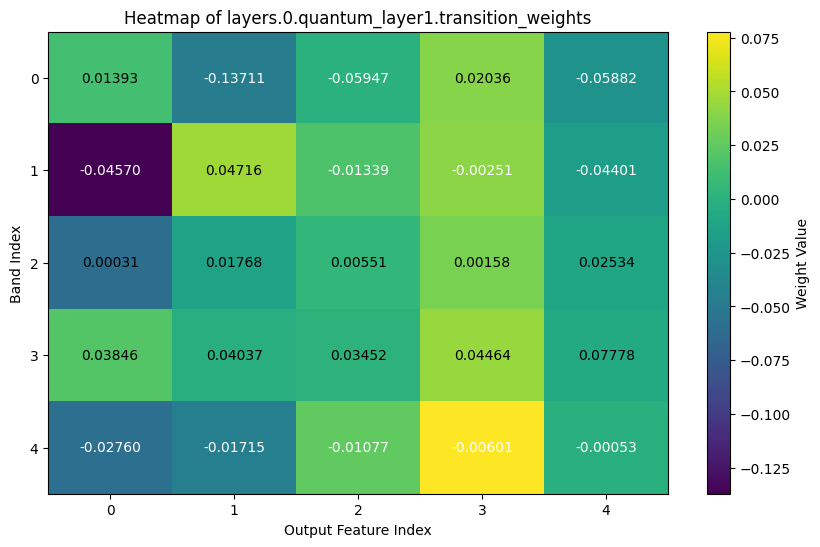

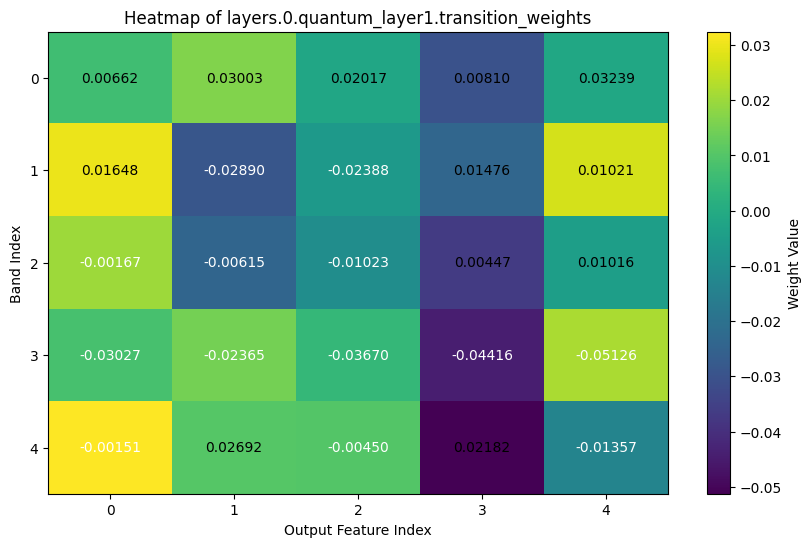

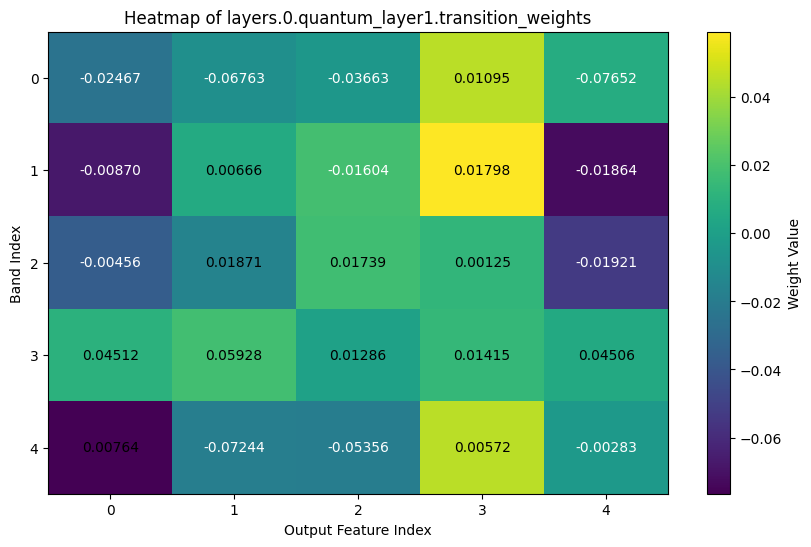

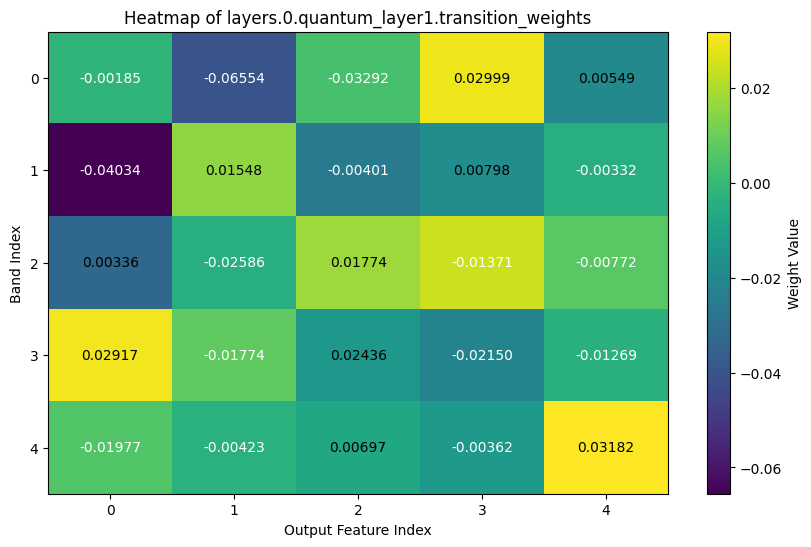

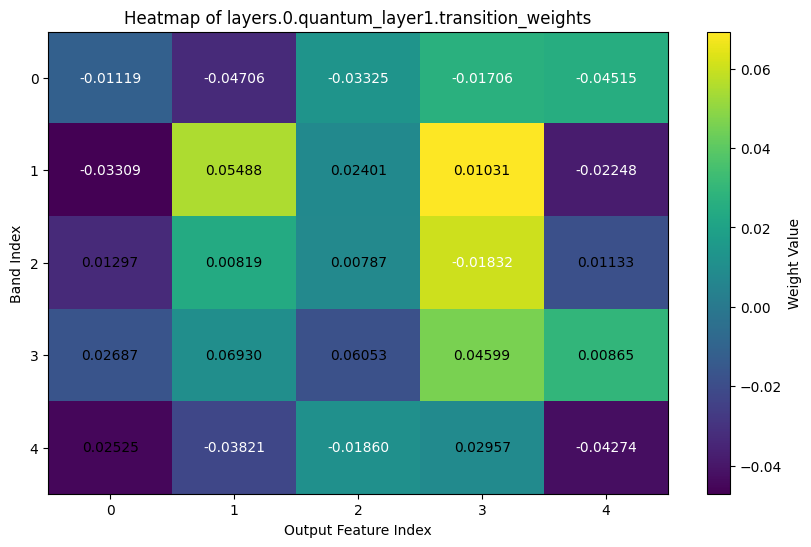

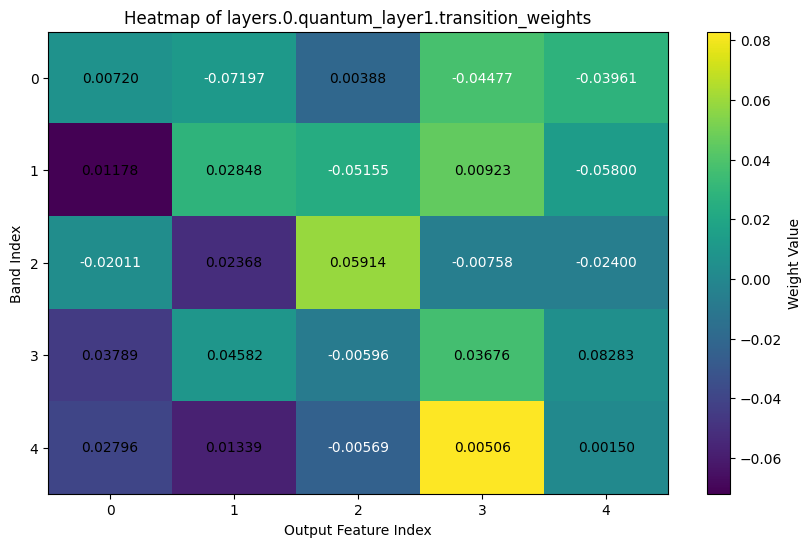

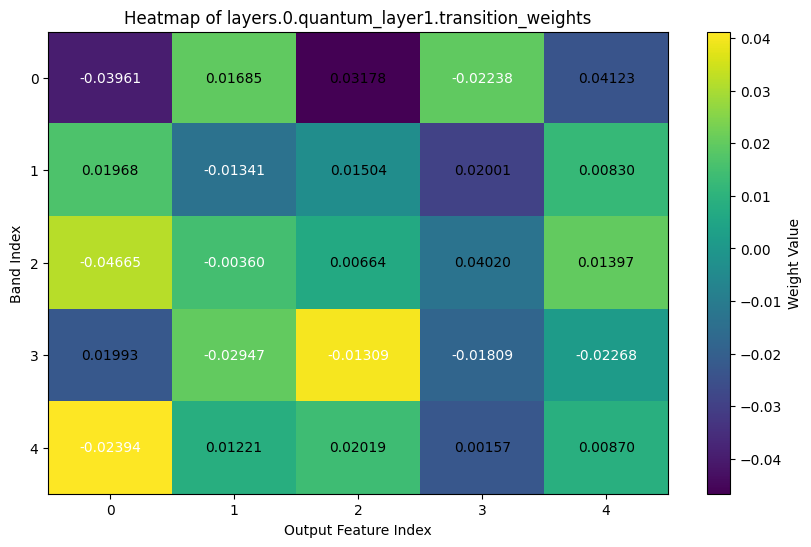

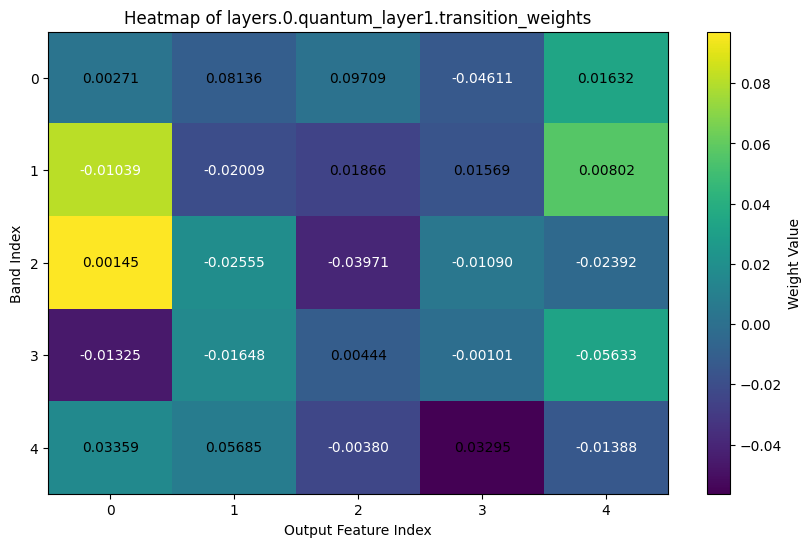

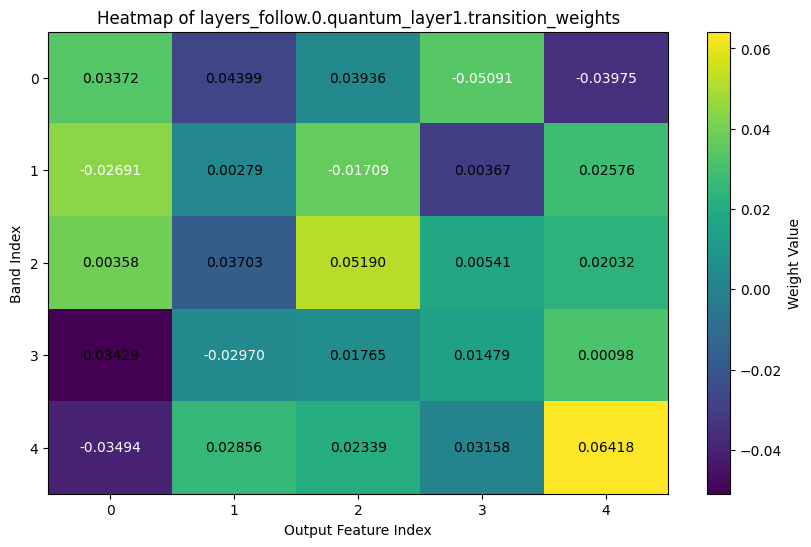

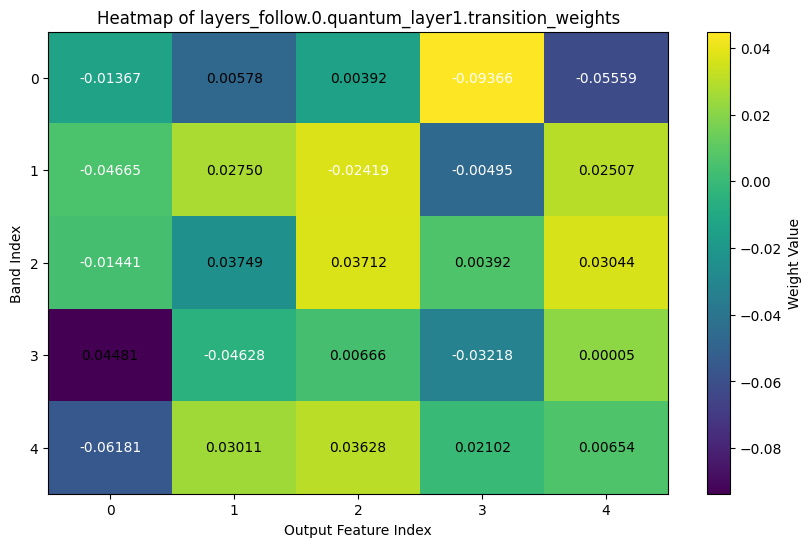

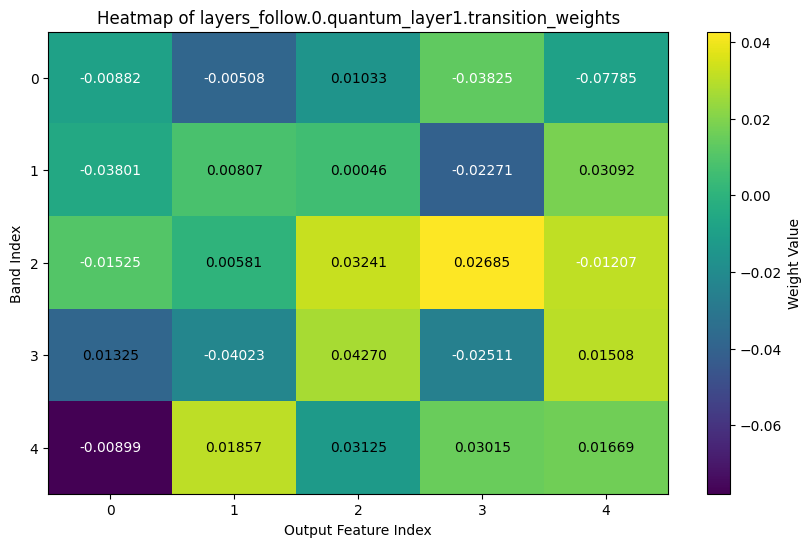

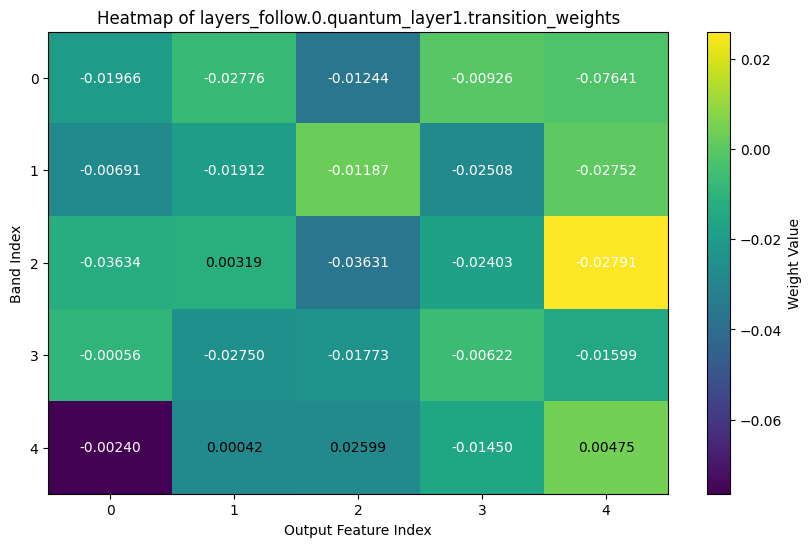

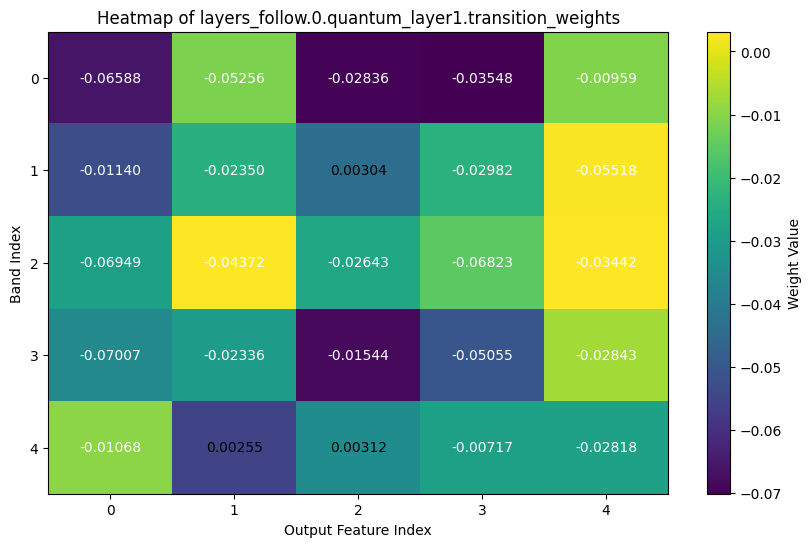

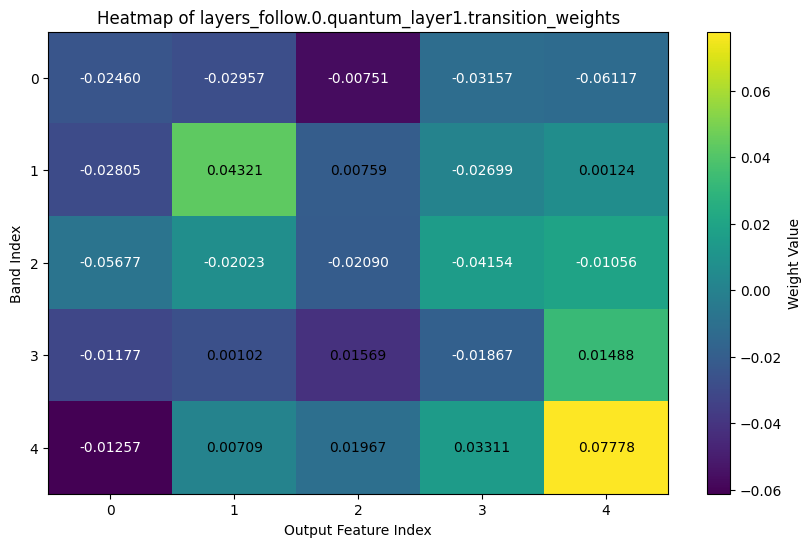

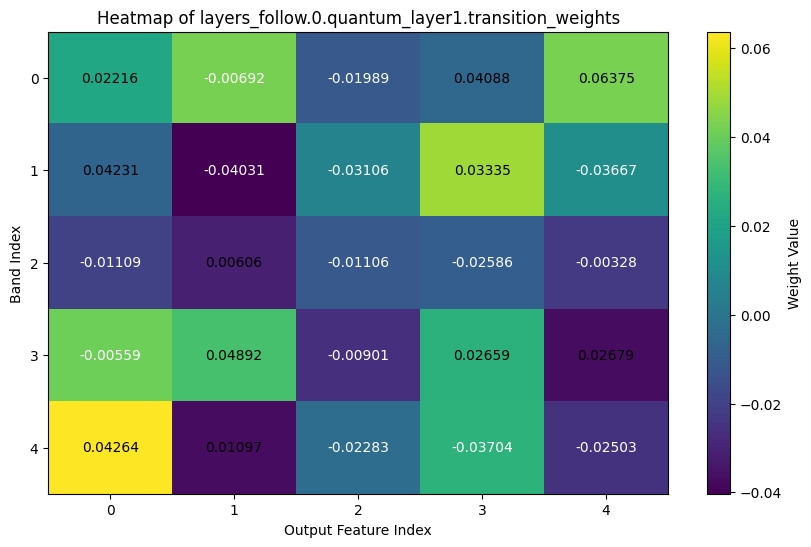

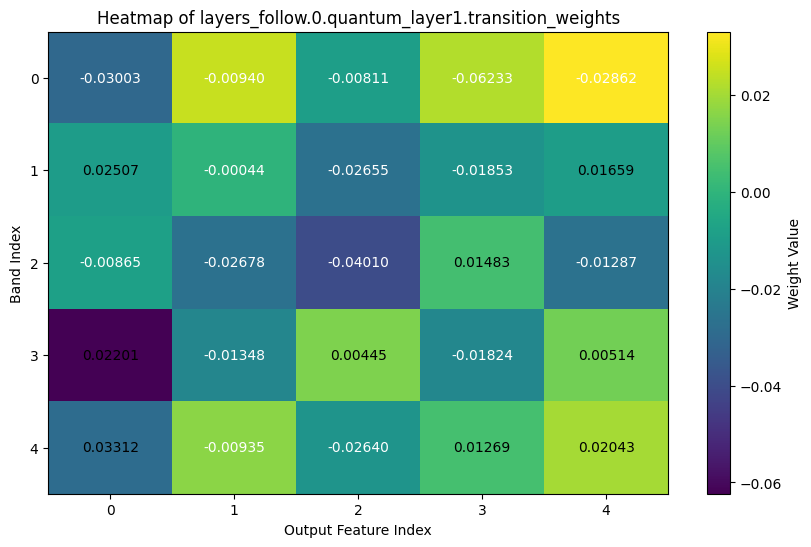

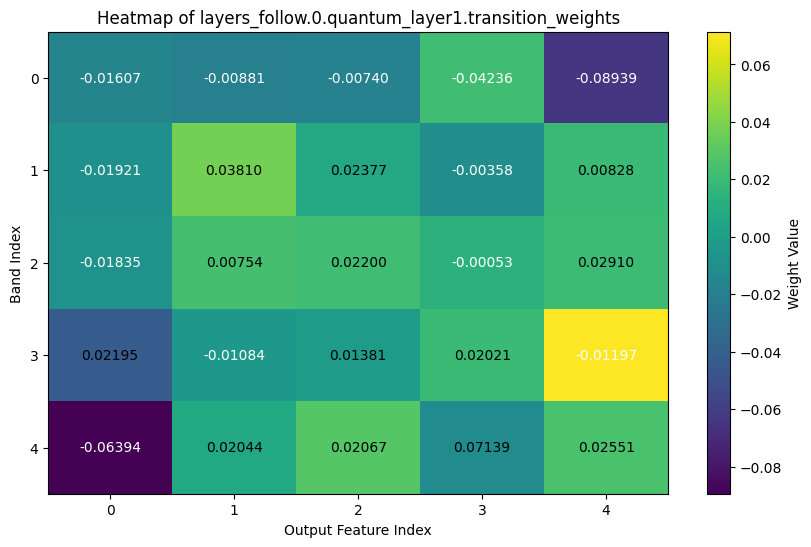

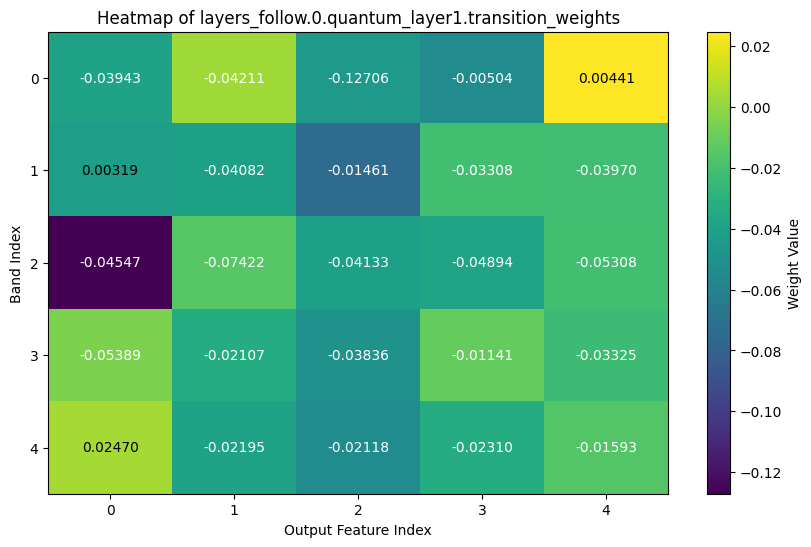

In [15]:
wg = model.named_parameters()

# Ищем transition_weights
for name, param in wg:
    if 'transition_weights' in name:
        w = param.to('cpu').detach().numpy()  # Преобразуем в numpy массив

        for i in range(min(10,w.shape[2])):
        # Создаем тепловую карту
            plt.figure(figsize=(10, 6))
            plt.title(f"Heatmap of {name}")
            
            # Используем imshow для тепловой карты
            plt.imshow(w[:,:,i], cmap='viridis', aspect='auto')
            
            # Добавляем цветовую шкалу
            plt.colorbar(label='Weight Value')
            
            # Подписи осей
            plt.xlabel('Output Feature Index')
            plt.ylabel('Band Index')
            
            # Добавляем аннотации (значения весов)
            for q in range(w.shape[0]):
                for k in range(w.shape[1]):
                    plt.text(q, k, f'{w[q, k,i]:.5f}', ha='center', va='center', color='white' if w[q, k,i] < 0 else 'black')
            
            plt.show()

<div style="background-color: #f4f4f9; padding: 20px; border-radius: 10px; text-align: center;">
    <b style="color: #53435c; font-weight: bold; margin-top: 15px;">визуализация параметров модели.</b>
</div>

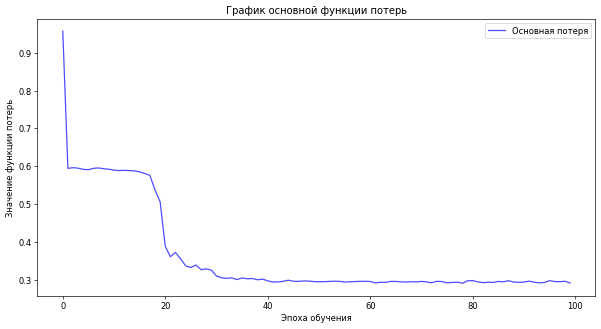

In [16]:
LV.show_training_loss()

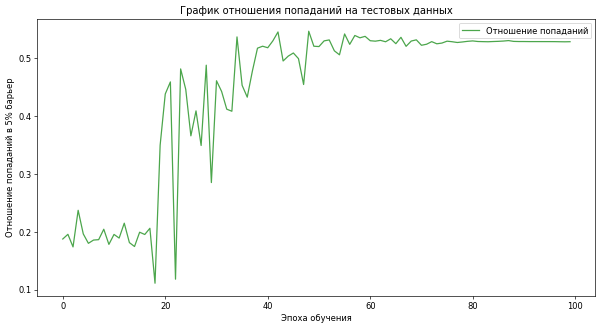

In [17]:
LV.show_test_tube()

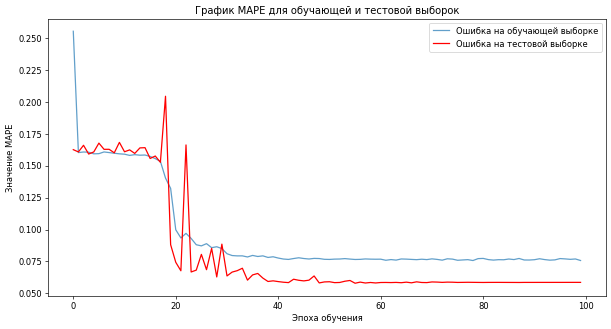

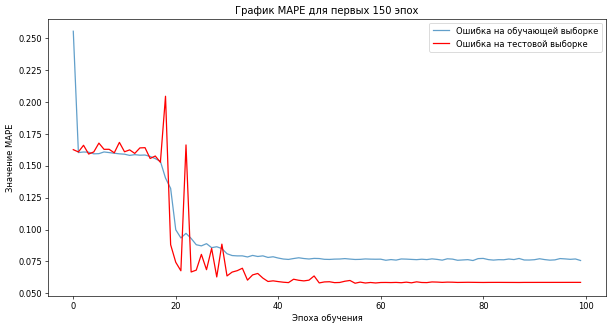

In [18]:
LV.show_mape()

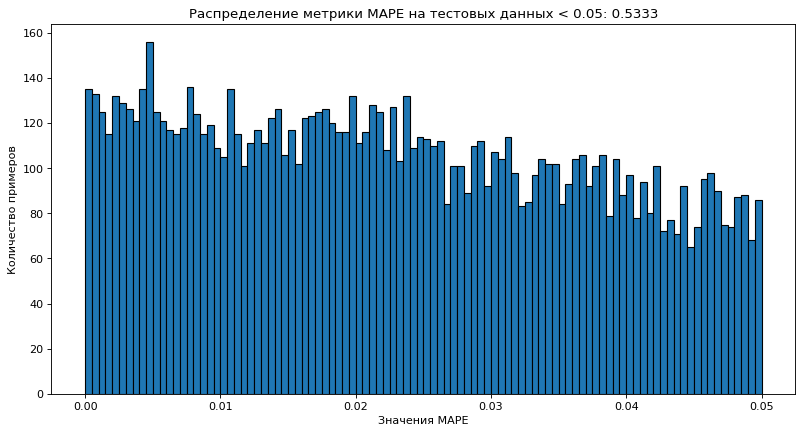

Процент значений MAPE < 0.05: 0.5333


In [8]:
LV = LossVisualizer([])
LV.histogram_mape(model,X_test[:1000,:],y_test[:1000,:],limit_percel = 5)

Количество записей: 5334


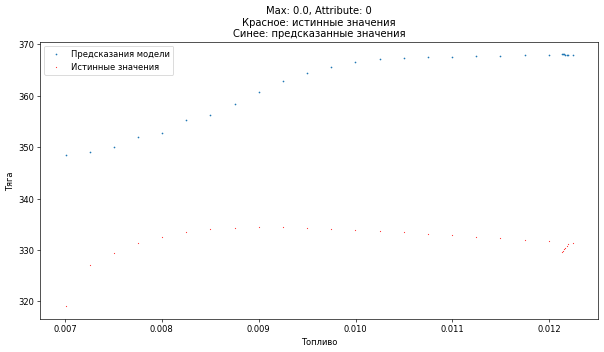

Количество записей: 5334


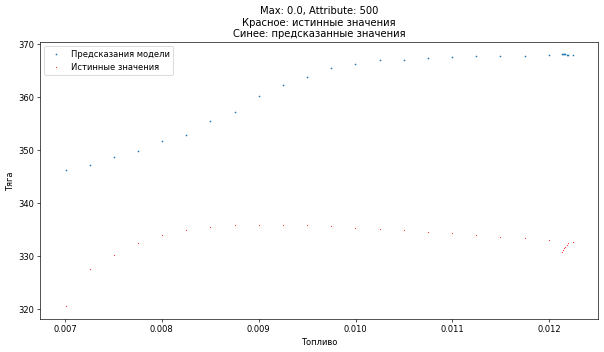

Количество записей: 5334


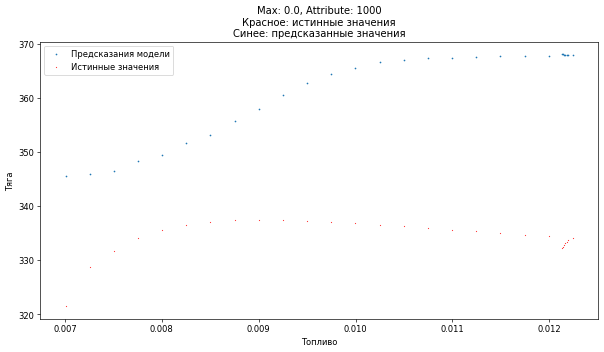

Количество записей: 5334


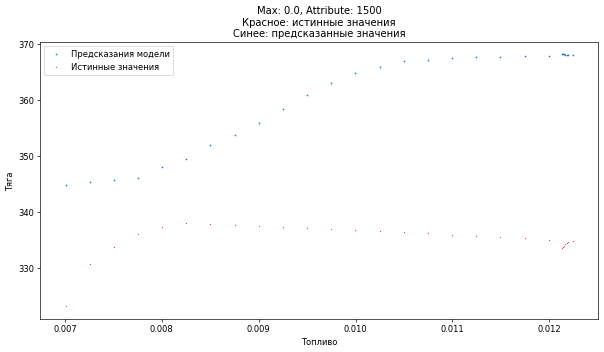

Количество записей: 5334


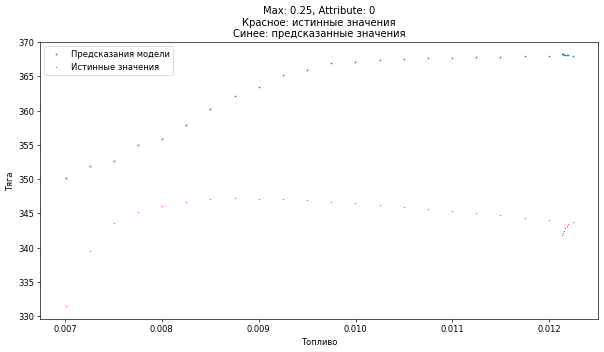

Количество записей: 5334


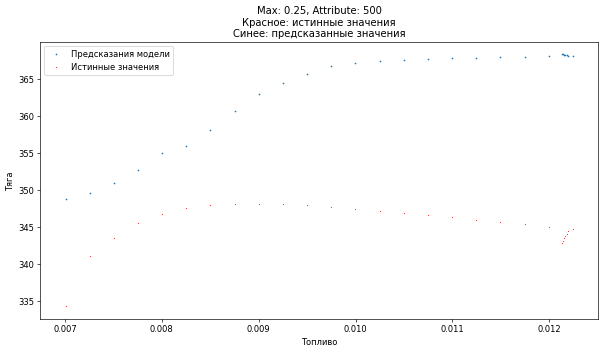

Количество записей: 5334


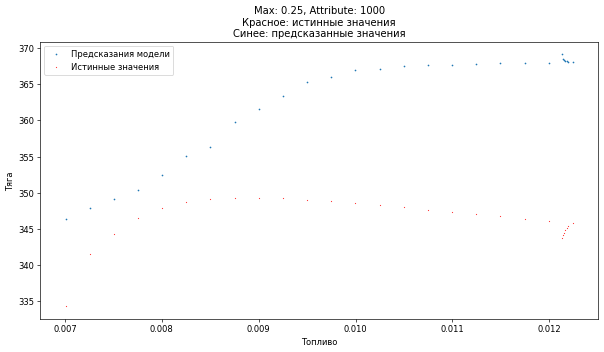

Количество записей: 5334


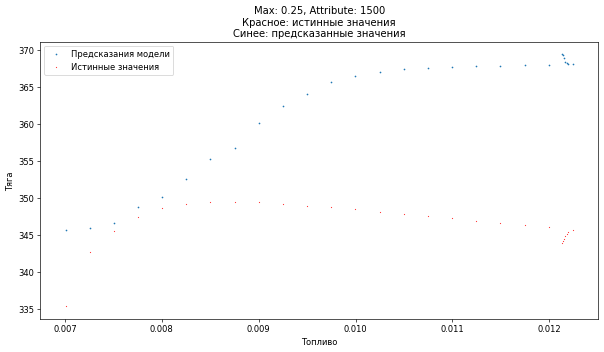

Количество записей: 5334


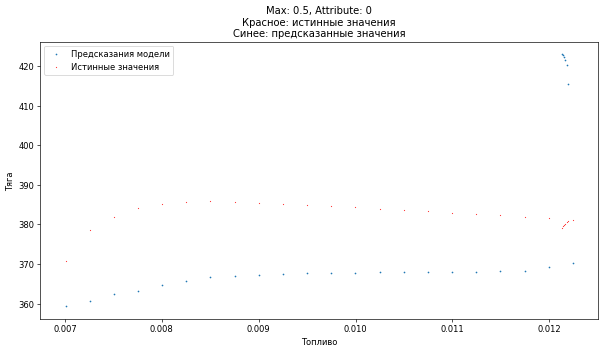

Количество записей: 5334


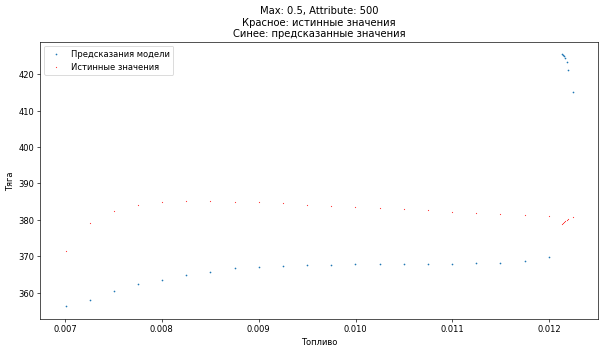

Количество записей: 5334


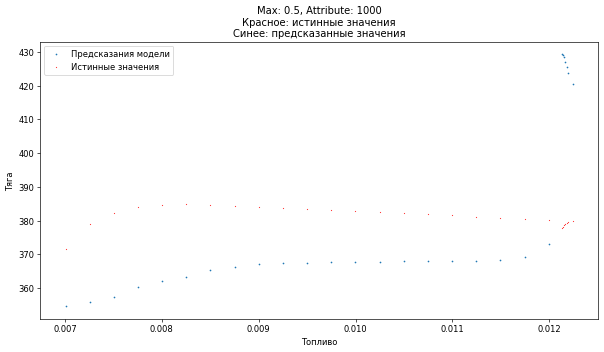

Количество записей: 5334


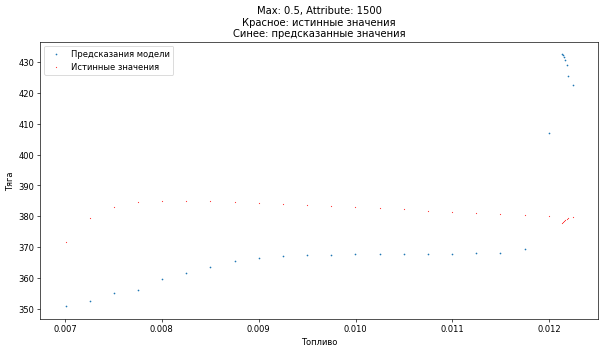

Количество записей: 5334


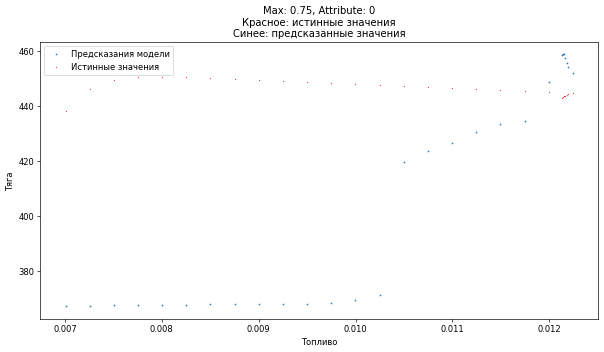

Количество записей: 5334


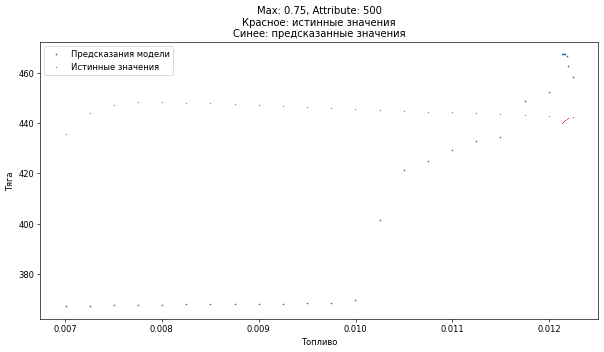

Количество записей: 5334


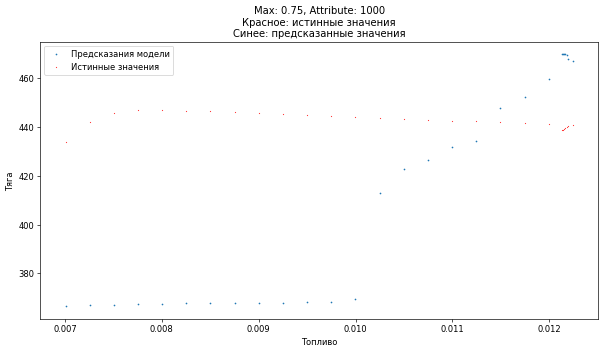

Количество записей: 5334


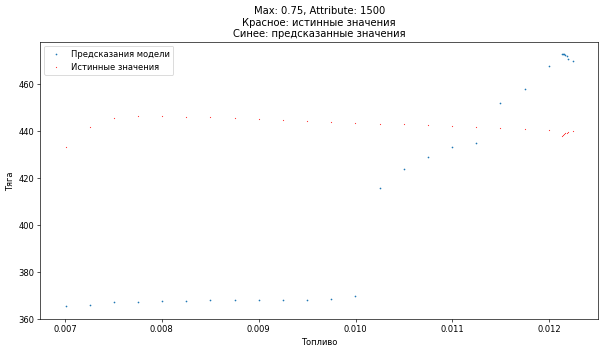

Количество записей: 5334


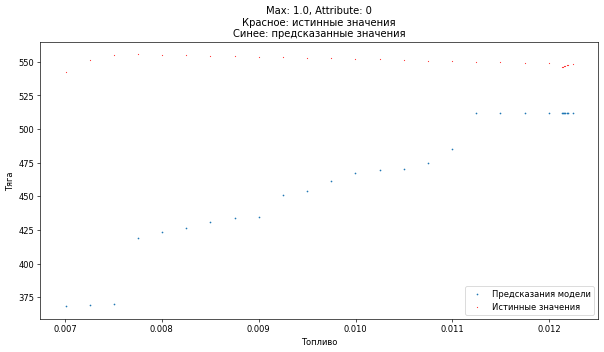

Количество записей: 5334


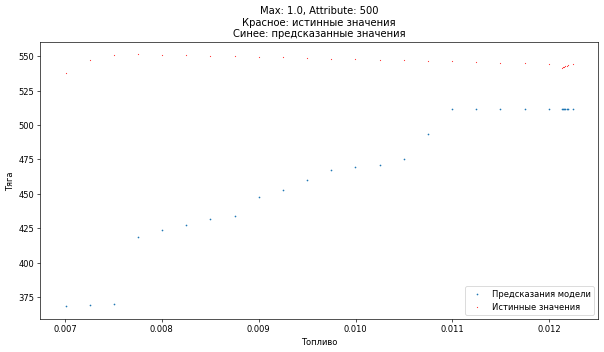

Количество записей: 5334


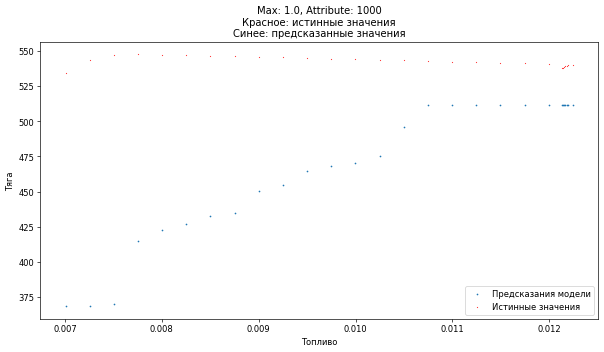

Количество записей: 5334


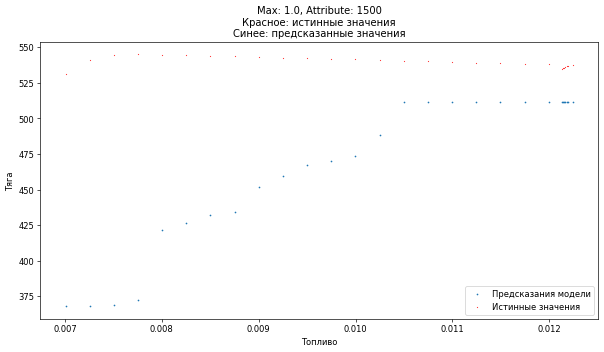

In [7]:
LV.show_predictions_rnn(model,df,(window_size,num_features,downsample_step,target_window_size),keras=False,device = device)

<div style="background-color: #f4f4f9; padding: 20px; border-radius: 10px; text-align: center;">
    <b style="color: #4f0c3e; font-weight: bold; margin-top: 15px;">визуализация примеров наглядное предсказание модели.</b>
</div>

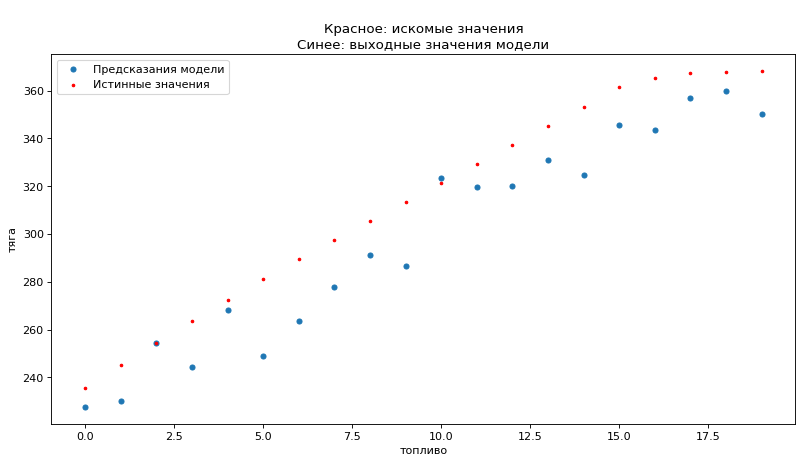

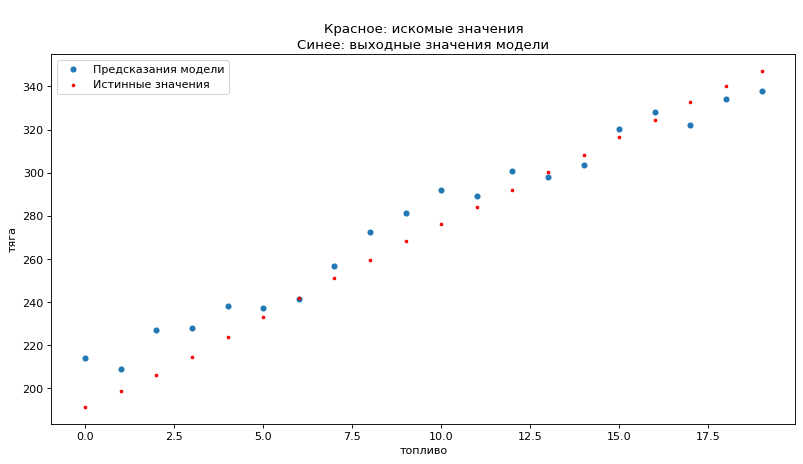

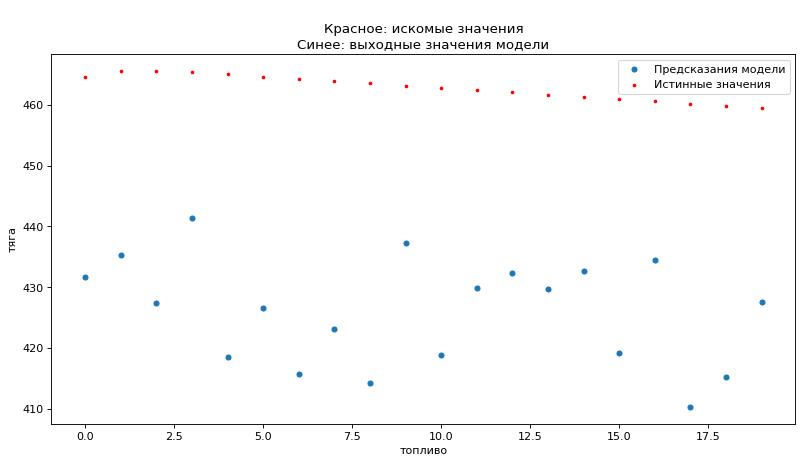

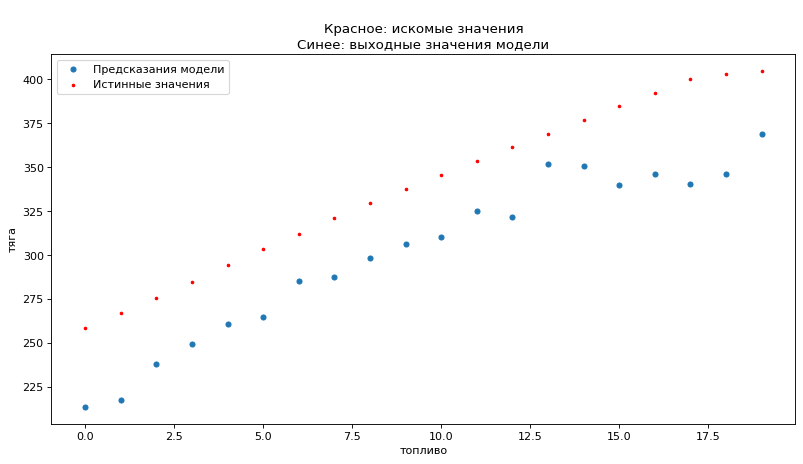

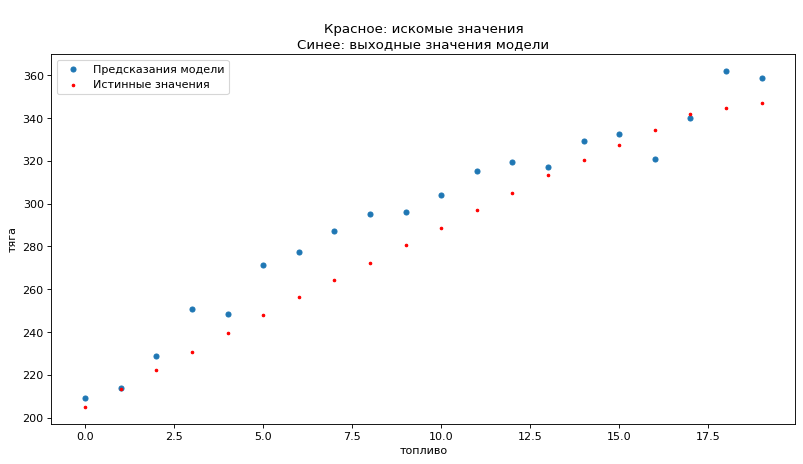

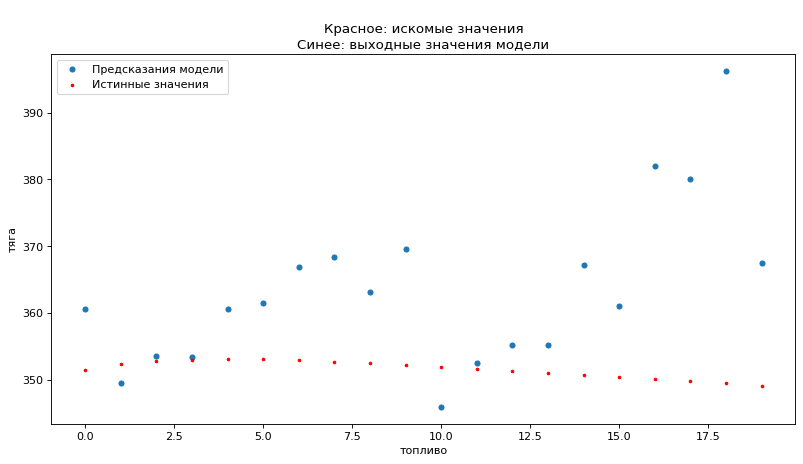

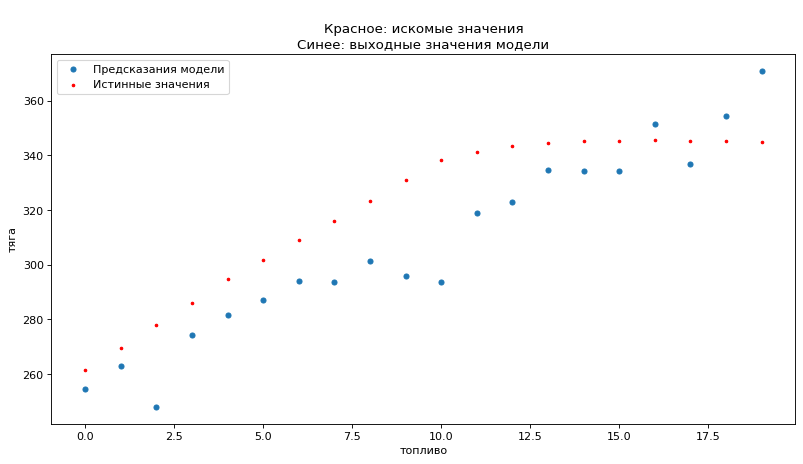

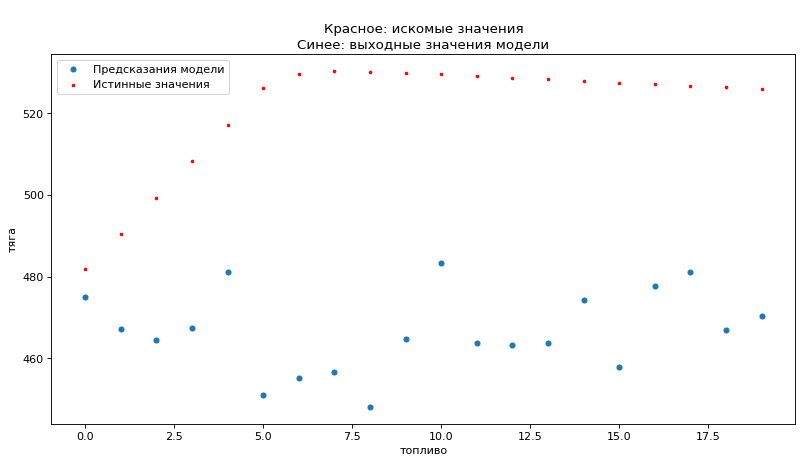

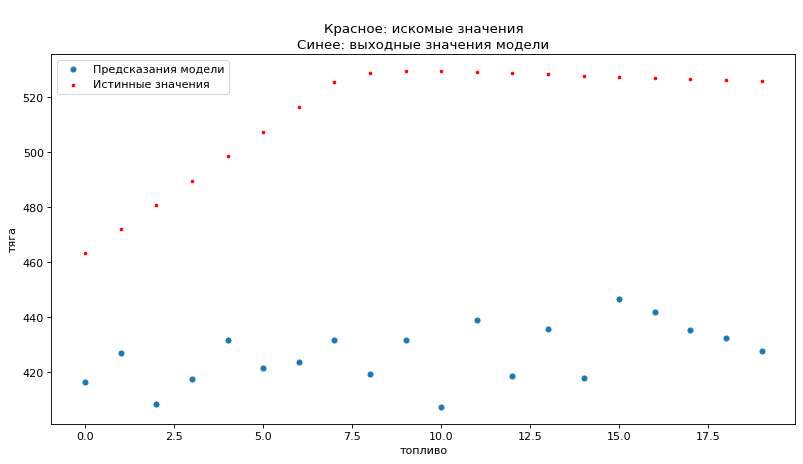

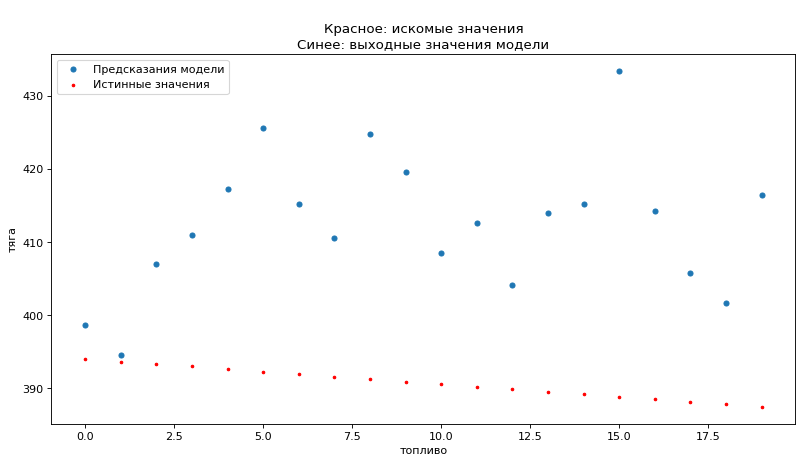

In [26]:
def gen_sample(ind):
    pred = model(X_test[ind:ind+1,:,:]).detach().to('cpu').to('cpu').detach().numpy()
    y_y = y_test[ind:ind+1,:].detach().to('cpu').to('cpu').detach().numpy()

    r = np.array([i for i in range(pred.shape[1])])
    plt.figure(figsize=(12, 6), dpi=80)
    plt.scatter(r, pred, s=20, label='Предсказания модели') 
    plt.scatter(r, y_y, color='r', s=5, label='Истинные значения') 
    plt.xlabel('топливо')  
    plt.ylabel('тяга')  
    plt.title(f'\nКрасное: искомые значения\nСинее: выходные значения модели')  
    plt.legend()  
    plt.show()
for i in range(10):
    gen_sample(i)
